In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from keras.optimizers import Adam
# Directories
TRAIN_DIR = '/kaggle/input/fer2013/train'
TEST_DIR = '/kaggle/input/fer2013/test'


2024-07-12 13:00:42.825900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 13:00:42.826052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 13:00:42.961986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# Function to create dataframe
def create_dataframe(dir):
    paths = []
    labels = []
    
    if not os.path.exists(dir):
        raise FileNotFoundError(f"Directory not found: {dir}")
    
    for label in os.listdir(dir):
        label_path = os.path.join(dir, label)
        if os.path.isdir(label_path):  # Check if the path is a directory
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                if os.path.isfile(image_path):  # Check if the path is a file
                    paths.append(image_path)
                    labels.append(label)
    
    return pd.DataFrame({'Image': paths, 'Label': labels})


In [3]:

# Creating dataframes for training and testing images
try:
    train = create_dataframe(TRAIN_DIR)
    test = create_dataframe(TEST_DIR)

    print("Training DataFrame:")
    print(train.head())
    print("Testing DataFrame:")
    print(test.head())
except FileNotFoundError as e:
    print(e)


Training DataFrame:
                                               Image     Label
0  /kaggle/input/fer2013/train/surprise/Training_...  surprise
1  /kaggle/input/fer2013/train/surprise/Training_...  surprise
2  /kaggle/input/fer2013/train/surprise/Training_...  surprise
3  /kaggle/input/fer2013/train/surprise/Training_...  surprise
4  /kaggle/input/fer2013/train/surprise/Training_...  surprise
Testing DataFrame:
                                               Image     Label
0  /kaggle/input/fer2013/test/surprise/PublicTest...  surprise
1  /kaggle/input/fer2013/test/surprise/PrivateTes...  surprise
2  /kaggle/input/fer2013/test/surprise/PrivateTes...  surprise
3  /kaggle/input/fer2013/test/surprise/PublicTest...  surprise
4  /kaggle/input/fer2013/test/surprise/PrivateTes...  surprise


In [4]:

# Function to extract features
def extract_features(image_paths):
    images = []
    for image_path in tqdm(image_paths):
        img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
        img = img_to_array(img)
        images.append(img)
    return np.array(images)



In [5]:
# Extracting features of training and testing images
try:
    trainFeatures = extract_features(train['Image'])
    testFeatures = extract_features(test['Image'])
    print("Train Features Shape:", trainFeatures.shape)
    print("Test Features Shape:", testFeatures.shape)
except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

  0%|          | 0/28709 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

Train Features Shape: (28709, 48, 48, 1)
Test Features Shape: (7178, 48, 48, 1)


In [6]:
# Normalizing the values of extracted features
trainImages = trainFeatures / 255.0
testImages = testFeatures / 255.0

print("Normalized Train Features Shape:", trainImages.shape)
print("Normalized Test Features Shape:", testImages.shape)

Normalized Train Features Shape: (28709, 48, 48, 1)
Normalized Test Features Shape: (7178, 48, 48, 1)


In [7]:
# Creating a label encoder
label_encoder = LabelEncoder()
label_encoder.fit(train['Label'])

LabelEncoder()

In [8]:
# Extracting and categorizing labels for the respective training and testing images
trainLabels = to_categorical(label_encoder.transform(train['Label']), num_classes=7)
testLabels = to_categorical(label_encoder.transform(test['Label']), num_classes=7)

In [9]:
# CNN Model for Facial Emotion Recognition
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Setting the learning rate for the optimizer
opt = Adam(learning_rate=0.0001)  # Adjust the learning rate as needed
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,232,199 (16.14 MB)

 Trainable params: 4,232,199 (16.14 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training the model
model.fit(x=trainImages, y=trainLabels, batch_size=64, epochs=100, validation_data=(testImages, testLabels))

Epoch 1/100
  5/449 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.1441 - loss: 1.9543 

I0000 00:00:1720789530.779499     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720789530.806005     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2354 - loss: 1.8499

W0000 00:00:1720789554.856174     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.2354 - loss: 1.8499 - val_accuracy: 0.2471 - val_loss: 1.8653
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2510 - loss: 1.8216 - val_accuracy: 0.2471 - val_loss: 1.8530
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2536 - loss: 1.8162 - val_accuracy: 0.2471 - val_loss: 1.8083
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.2574 - loss: 1.7875 - val_accuracy: 0.3098 - val_loss: 1.7296
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3080 - loss: 1.6980 - val_accuracy: 0.3831 - val_loss: 1.5968
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.3815 - loss: 1.5758 - val_accuracy: 0.4419 - val_loss: 1.4460
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4320 - loss: 1.4689 - val_accuracy: 0.4695 - val_loss: 1.3955
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.4612 - loss: 1.3997 - val_

In [12]:
# Save the model as JSON file
model_json = model.to_json()
with open("facialEmotionRecognition.json", "w") as json_file:
    json_file.write(model_json)

model.save("facialEmotionRecognition.h5")

In [13]:
# # Load the model
# json_file = open("facialEmotionRecognition.json", "r")
# model_json = json_file.read()
# json_file.close()

# model = model_from_json(model_json)
# model.load_weights("facialEmotionRecognition.h5")

In [14]:
# Load the model from JSON file
json_file = open('facialEmotionRecognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("facialEmotionRecognition.h5")
print("Loaded model from disk")

# Compile the loaded model
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the loaded model
train_loss, train_accuracy = loaded_model.evaluate(trainImages, trainLabels)
test_loss, test_accuracy = loaded_model.evaluate(testImages, testLabels)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Loaded model from disk
898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9949 - loss: 0.0229


W0000 00:00:1720790658.769423     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6334 - loss: 1.4646
Training Accuracy: 99.68%
Testing Accuracy: 64.41%


In [15]:
# List of emotion labels
label = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [16]:
# Function to extract features of a particular image
def extract_image_features(image):
    img = load_img(image, color_mode='grayscale', target_size=(48, 48))
    feature = img_to_array(img)
    feature = feature.reshape(1, 48, 48, 1)
    return feature / 255.0

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
model prediction is  sad


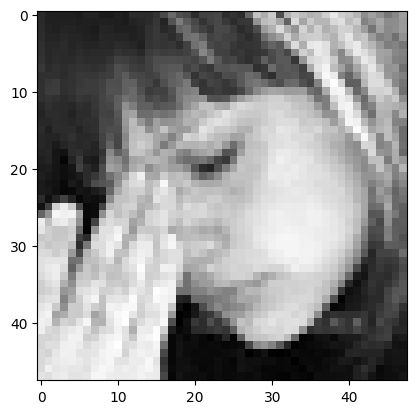

In [22]:
image = '/kaggle/input/fer2013/test/sad/PrivateTest_10702106.jpg'
print("original image is of sad")
img = extract_image_features(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
model prediction is  surprise


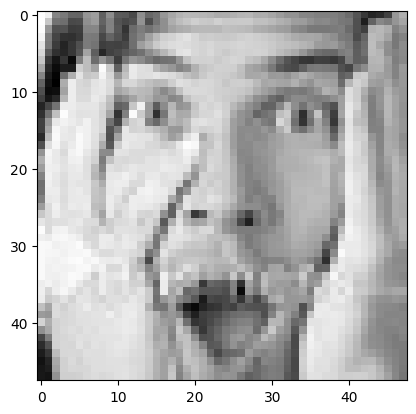

In [24]:
image = '/kaggle/input/fer2013/test/surprise/PrivateTest_10072988.jpg'
print("original image is of surprise")
img = extract_image_features(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
model prediction is  neutral


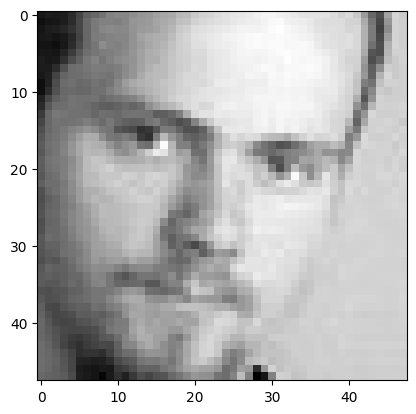

In [25]:
image = '/kaggle/input/fer2013/test/neutral/PrivateTest_10086748.jpg'
print("original image is of neutral")
img = extract_image_features(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
model prediction is  happy


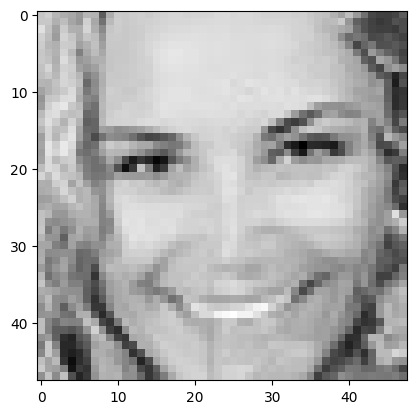

In [26]:
image = '/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg'
print("original image is of happy")
img = extract_image_features(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
model prediction is  fear


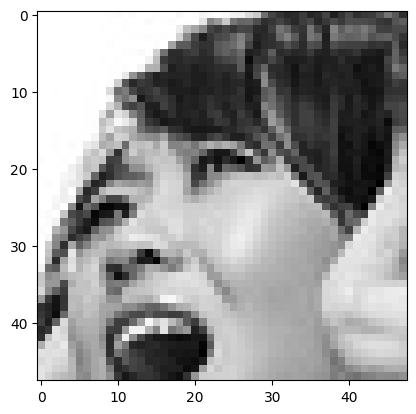

In [27]:
image = '/kaggle/input/fer2013/test/fear/PrivateTest_10153550.jpg'
print("original image is of fear")
img = extract_image_features(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
model prediction is  disgust


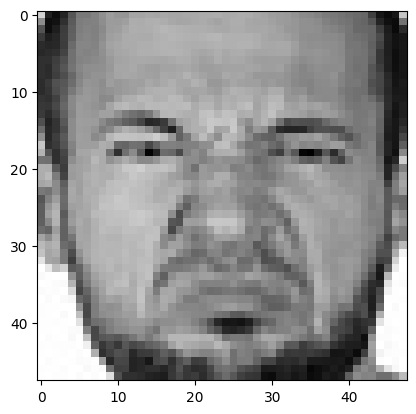

In [31]:
image = '/kaggle/input/fer2013/test/disgust/PrivateTest_22382996.jpg'
print("original image is of disgust")
img = extract_image_features(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
model prediction is  angry


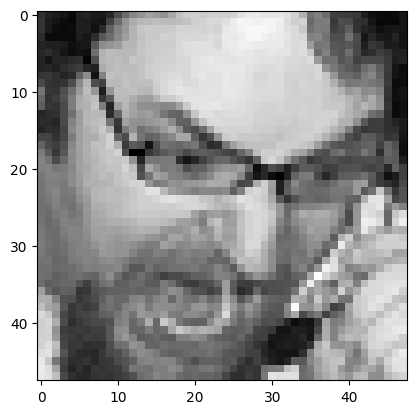

In [32]:
image = '/kaggle/input/fer2013/test/angry/PrivateTest_10131363.jpg'
print("original image is of angry")
img = extract_image_features(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')